# Load RU29 processed ADCP data and compute transect transports but psuedo sample like WOCE A22 line

## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from geopy.distance import geodesic
from scipy.interpolate import interp1d
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.feature as cpf


def calc_segment_transport(ds):
    segment_dist = np.empty(len(ds.time))
    segment_dist[:] = np.nan
    segment_transport = np.empty(len(ds.time))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.time)):
        segment_dist[x] = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        segment_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist[x]*dz)
    
    ds["segment_transport"] = (("time"), segment_transport)
    ds["segment_dist"] = (("time"), segment_dist)

    return ds


def calc_segment_transport_interp(ds):
    segment_dist = np.empty(len(ds.latitude))
    segment_dist[:] = np.nan
    segment_transport = np.empty(len(ds.latitude))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.latitude)):
        segment_dist[x] = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        segment_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist[x]*dz)
    
    ds["segment_transport"] = (("latitude"), segment_transport)
    ds["segment_dist"] = (("latitude"), segment_dist)

    return ds



fontsize = 12

## Load data

In [ ]:
# a22 = xr.open_dataset("/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/A22/316N151_4_ctd.nc")
# a22velocity = xr.open_dataset("/Users/joegradone/SynologyDrive/Drive/Rutgers/Research/data/A22/r0012.nc")
# a22

DEPRECATION: Loading egg at /Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/scs-3.2.7.post2-py3.11-macosx-11.0-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/matplotlib-3.7.5-py3.11-macosx-11.0-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at /Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cvxpy-1.6.4-py3.11-macosx-11.0-arm64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip

<xarray.Dataset>
Dimensions:             (N_PROF: 77, N_LEVELS: 3057)
Coordinates:
    expocode            (N_PROF) object ...
    station             (N_PROF) object ...
    cast                (N_PROF) int32 ...
    sample              (N_PROF, N_LEVELS) object ...
    time                (N_PROF) datetime64[ns] ...
    latitude            (N_PROF) float64 ...
    longitude           (N_PROF) float64 ...
    pressure            (N_PROF, N_LEVELS) float64 ...
Dimensions without coordinates: N_PROF, N_LEVELS
Data variables:
    section_id          (N_PROF) object ...
    btm_depth           (N_PROF) float64 ...
    pressure_qc         (N_PROF, N_LEVELS) float32 ...
    ctd_temperature     (N_PROF, N_LEVELS) float64 ...
    ctd_temperature_qc  (N_PROF, N_LEVELS) float32 ...
    ctd_salinity        (N_PROF, N_LEVELS) float64 ...
    ctd_salinity_qc     (N_PROF, N_LEVELS) float32 ...
    ctd_oxygen          (N_PROF, N_LEVELS) float64 ...
    ctd_oxygen_qc       (N_PROF, N_LEVELS) float32 ...
    profile_type        (N_PROF) object ...
    geometry_container  float64 ...
Attributes:
    Conventions:               CF-1.8 CCHDO-1.0
    cchdo_software_version:    hydro 1.0.2.3
    cchdo_parameters_version:  params 0.1.21
    comments:                  CTD,20011226WHPOSIOKJU\nSoftware Version: CTD_...
    featureType:               profile

/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/joegradone/anaconda3/envs/rutgers-phd/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


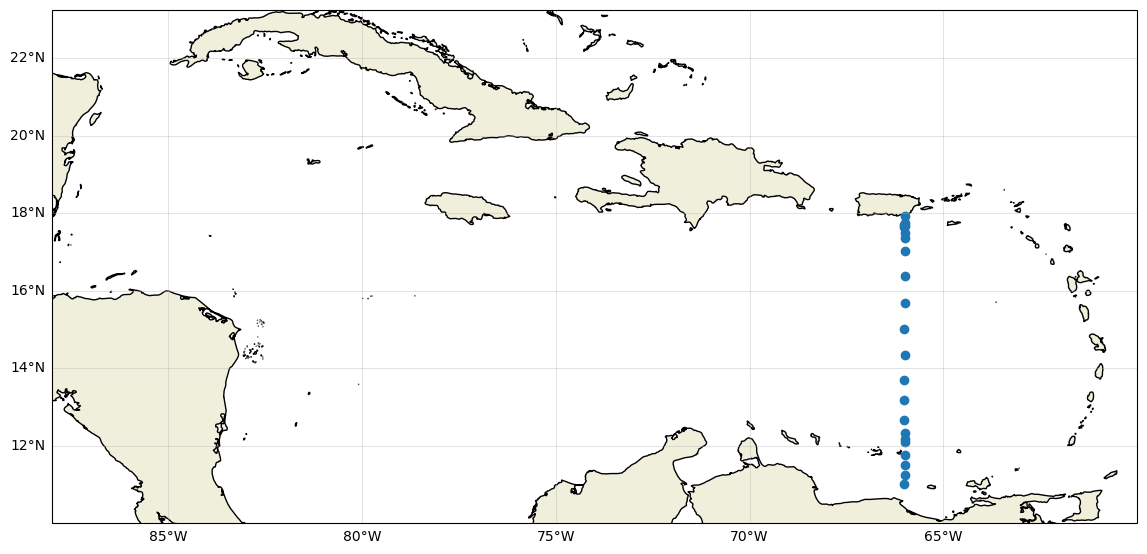

In [4]:
## Map extent
lon1 = -88
lon2 = -60
lat1 = 10
lat2 = 23


fig = plt.figure(figsize=(14,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon1, lon2, lat1, lat2])



LAND = cfeature.NaturalEarthFeature(
    'physical', 'land', '10m',
    edgecolor='black',
    facecolor=cfeature.COLORS['land']
)
ax.add_feature(LAND, zorder=1)


glb = ax.gridlines(draw_labels=True, alpha=0.5, linewidth=.5 )
glb.xlabels_top = glb.ylabels_right = False


subset = a22.where(
    (a22.latitude < 18) &
    (a22.longitude > -67) &
    (a22.longitude < -65.5),
    drop=True
)


plt.scatter(subset.longitude, subset.latitude)

In [5]:
subset.N_PROF

<xarray.DataArray 'N_PROF' (N_PROF: 22)>
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21])
Coordinates:
    expocode   (N_PROF) object '316N151_4' '316N151_4' ... '316N151_4'
    station    (N_PROF) object '2' '3' '4' '5' '6' ... '19' '20' '21' '22' '23'
    cast       (N_PROF) int32 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
    time       (N_PROF) datetime64[ns] 1997-08-16T19:13:00.000000256 ... 1997...
    latitude   (N_PROF) float64 11.0 11.25 11.5 11.75 ... 17.66 17.7 17.75 17.93
    longitude  (N_PROF) float64 -66.0 -66.0 -66.0 -65.99 ... -66.0 -66.0 -66.0
Dimensions without coordinates: N_PROF

In [ ]:
ds = xr.open_dataset('../data/processed_nc/RU29_2024_Processed_AD2CP.nc')
ds

<xarray.Dataset>
Dimensions:     (depth: 100, time: 486)
Coordinates:
  * time        (time) datetime64[ns] 2024-04-19T14:50:04 ... 2024-06-30T16:5...
  * depth       (depth) float64 5.0 15.0 25.0 35.0 ... 965.0 975.0 985.0 995.0
Data variables:
    u_grid      (depth, time) float64 ...
    v_grid      (depth, time) float64 ...
    latitude    (time) float64 ...
    longitude   (time) float64 ...
    start_lat   (time) float64 ...
    start_lon   (time) float64 ...
    end_lat     (time) float64 ...
    end_lon     (time) float64 ...
    start_time  (time) datetime64[ns] ...
    end_time    (time) datetime64[ns] ...
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

## Subset to transects

In [7]:
## Taken from RU29_ABC2DR_Analysis.ipynb
transect1_start_time = pd.to_datetime('2024-04-27T20:05:00Z').tz_localize(None) ## transect 1 start time
transect1_end_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 1 end time
transect2_start_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 2 start time
transect2_end_time = pd.to_datetime('2024-06-06T00:00:00Z').tz_localize(None) ## transect 2 end time

transect1_ds = ds.sel(time=slice(transect1_start_time,transect1_end_time))
transect2_ds = ds.sel(time=slice(transect2_start_time,transect2_end_time))


transect1_ds = calc_segment_transport(transect1_ds)
transect2_ds = calc_segment_transport(transect2_ds)
transect2_ds

<xarray.Dataset>
Dimensions:            (depth: 100, time: 121)
Coordinates:
  * time               (time) datetime64[ns] 2024-05-18T12:01:06 ... 2024-06-...
  * depth              (depth) float64 5.0 15.0 25.0 35.0 ... 975.0 985.0 995.0
Data variables:
    u_grid             (depth, time) float64 ...
    v_grid             (depth, time) float64 ...
    latitude           (time) float64 ...
    longitude          (time) float64 ...
    start_lat          (time) float64 ...
    start_lon          (time) float64 ...
    end_lat            (time) float64 ...
    end_lon            (time) float64 ...
    start_time         (time) datetime64[ns] ...
    end_time           (time) datetime64[ns] ...
    segment_transport  (time) float64 -1.424e+04 -9.009e+04 ... -3.158e+05
    segment_dist       (time) float64 525.6 4.258e+03 ... 3.784e+03 3.916e+03
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

In [8]:
print('Trasect #1 Latitude Range:',np.round(transect1_ds.latitude.min().values,3),'to',np.round(transect1_ds.latitude.max().values,3))
print('Trasect #2 Latitude Range:',np.round(transect2_ds.latitude.min().values,3),'to',np.round(transect2_ds.latitude.max().values,3))


Trasect #1 Latitude Range: 12.602 to 17.739
Trasect #2 Latitude Range: 12.589 to 17.716


Text(0.5, 0, 'Segment Distance (m)')

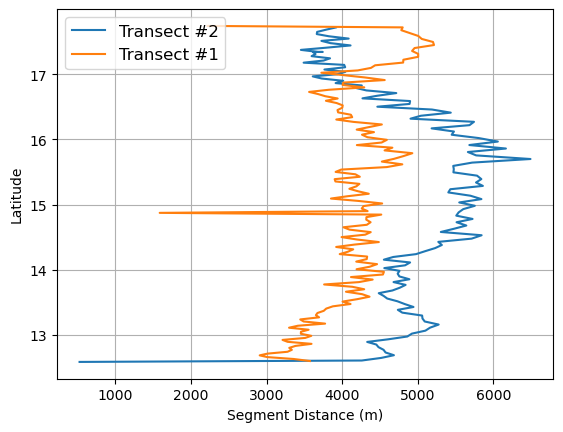

In [9]:
plt.plot(transect2_ds.segment_dist,transect2_ds.latitude,label='Transect #2')
plt.plot(transect1_ds.segment_dist,transect1_ds.latitude,label='Transect #1')
plt.legend(fontsize=fontsize)
plt.grid()
plt.ylabel('Latitude')
plt.xlabel('Segment Distance (m)')

In [10]:
print('Transect 1 Median Segment Distance ',np.round(np.nanmedian(transect1_ds.segment_dist)/1000,2),'km')
print('Transect 2 Median Segment Distance ',np.round(np.nanmedian(transect2_ds.segment_dist)/1000,2),'km')
print('')
print('Transect 1 Mean Segment Distance ',np.round(np.nanmean(transect1_ds.segment_dist)/1000,2),'km')
print('Transect 2 Mean Segment Distance ',np.round(np.nanmean(transect2_ds.segment_dist)/1000,2),'km')

Transect 1 Median Segment Distance  4.17 km
Transect 2 Median Segment Distance  4.83 km

Transect 1 Mean Segment Distance  4.1 km
Transect 2 Mean Segment Distance  4.78 km


In [11]:
# Define your min and max latitudes (in degrees)
min_lat = transect1_ds.latitude.min().values
max_lat = transect1_ds.latitude.max().values

# Define the constant longitude
longitude = -69.0

# 1 degree latitude ≈ 111.32 km
km = 5.5
lat_step_deg = km / 111.32

# Create the latitude grid
lat_grid = subset.latitude.values



In [12]:

def interpolate_all_profiles_to_lat_grid(ds, lat_grid, const_lon=-69.0):
    """
    Interpolates u_grid and v_grid from all profiles onto lat_grid.
    Saves start/end lat/lon, n_profs, and mean time per lat bin.

    Parameters:
        ds (xr.Dataset): input dataset with 'latitude' (time), 'u_grid', 'v_grid' (depth, time)
        lat_grid (1D array): latitude centers
        const_lon (float): constant longitude for output

    Returns:
        xr.Dataset with dims:
          - depth
          - latitude (interpolation grid)
        variables:
          - u_grid(depth, latitude)
          - v_grid(depth, latitude)
          - n_profs(latitude)
          - mean_time(latitude)  # mean time of profiles in each lat bin
          - start_lat(latitude)
          - end_lat(latitude)
          - start_lon(latitude)
          - end_lon(latitude)
          - longitude(latitude)
    """
    lats = ds['latitude'].values      # (time,)
    u = ds['u_grid'].values           # (depth, time)
    v = ds['v_grid'].values
    depth = ds['depth'].values
    time = ds['time'].values          # numpy datetime64 or numeric

    n_depth = len(depth)
    n_lat = len(lat_grid)

    u_interp = np.full((n_depth, n_lat), np.nan)
    v_interp = np.full((n_depth, n_lat), np.nan)

    # Bin edges
    bin_width = np.diff(lat_grid).mean() if len(lat_grid) > 1 else 0.05
    half_bin = bin_width / 2
    start_lat = lat_grid - half_bin
    end_lat = lat_grid + half_bin
    start_lon = np.full_like(lat_grid, const_lon)
    end_lon = np.full_like(lat_grid, const_lon)

    # Compute n_profs and mean_time per lat bin
    n_profs = np.empty(n_lat, dtype=int)
    mean_time = np.full(n_lat, np.nan, dtype='float64')

    for i, (s_lat, e_lat) in enumerate(zip(start_lat, end_lat)):
        in_bin_mask = (lats >= s_lat) & (lats < e_lat)
        n_profs[i] = np.sum(in_bin_mask)
        if n_profs[i] > 0:
            # Handle numeric or datetime64 time arrays
            times_in_bin = time[in_bin_mask]
            # If datetime64, convert to float for mean then back
            if np.issubdtype(time.dtype, np.datetime64):
                mean_ts = times_in_bin.astype('datetime64[ns]').astype('int64').mean()
                mean_time[i] = np.datetime64(int(mean_ts), 'ns').astype('float64')
            else:
                mean_time[i] = times_in_bin.mean()
        else:
            mean_time[i] = np.nan

    # Interpolate u, v at each depth across all valid profiles
    for i in range(n_depth):
        valid_mask = np.isfinite(lats) & np.isfinite(u[i, :]) & np.isfinite(v[i, :])
        if np.sum(valid_mask) < 2:
            continue

        lat_valid = lats[valid_mask]
        u_valid = u[i, valid_mask]
        v_valid = v[i, valid_mask]

        sort_idx = np.argsort(lat_valid)
        lat_sorted = lat_valid[sort_idx]
        u_sorted = u_valid[sort_idx]
        v_sorted = v_valid[sort_idx]

        f_u = interp1d(lat_sorted, u_sorted, bounds_error=False, fill_value=np.nan)
        f_v = interp1d(lat_sorted, v_sorted, bounds_error=False, fill_value=np.nan)

        u_interp[i, :] = f_u(lat_grid)
        v_interp[i, :] = f_v(lat_grid)

    # Convert mean_time back to datetime64 if input time was datetime64
    if np.issubdtype(time.dtype, np.datetime64):
        mean_time = mean_time.astype('int64')
        mean_time = mean_time.astype('datetime64[ns]')

    # Assemble Dataset
    out_ds = xr.Dataset(
        {
            "u_grid": (("depth", "latitude"), u_interp),
            "v_grid": (("depth", "latitude"), v_interp),
            "n_profs": (("latitude",), n_profs),
            "time": (("latitude",), mean_time),
            "start_lat": (("latitude",), start_lat),
            "end_lat": (("latitude",), end_lat),
            "start_lon": (("latitude",), start_lon),
            "end_lon": (("latitude",), end_lon),
        },
        coords={
            "depth": depth,
            "latitude": lat_grid,
            "longitude": (("latitude",), np.full_like(lat_grid, const_lon)),
        }
    )

    return out_ds


In [13]:
transect1_ds_interp = interpolate_all_profiles_to_lat_grid(transect1_ds, lat_grid)
transect2_ds_interp = interpolate_all_profiles_to_lat_grid(transect2_ds, lat_grid)
transect1_ds_interp

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_62835/1116795792.py:88: RuntimeWarning: invalid value encountered in cast
  mean_time = mean_time.astype('int64')


<xarray.Dataset>
Dimensions:    (depth: 100, latitude: 22)
Coordinates:
  * depth      (depth) float64 5.0 15.0 25.0 35.0 ... 965.0 975.0 985.0 995.0
  * latitude   (latitude) float64 11.0 11.25 11.5 11.75 ... 17.7 17.75 17.93
    longitude  (latitude) float64 -69.0 -69.0 -69.0 -69.0 ... -69.0 -69.0 -69.0
Data variables:
    u_grid     (depth, latitude) float64 nan nan nan nan ... 0.00107 nan nan
    v_grid     (depth, latitude) float64 nan nan nan nan ... -0.001393 nan nan
    n_profs    (latitude) int64 0 0 0 0 0 0 0 8 10 9 9 9 8 9 9 7 7 7 6 6 5 0
    time       (latitude) datetime64[ns] 1970-01-01 1970-01-01 ... 1970-01-01
    start_lat  (latitude) float64 10.84 11.08 11.34 11.59 ... 17.53 17.58 17.77
    end_lat    (latitude) float64 11.17 11.41 11.67 11.92 ... 17.86 17.91 18.1
    start_lon  (latitude) float64 -69.0 -69.0 -69.0 -69.0 ... -69.0 -69.0 -69.0
    end_lon    (latitude) float64 -69.0 -69.0 -69.0 -69.0 ... -69.0 -69.0 -69.0

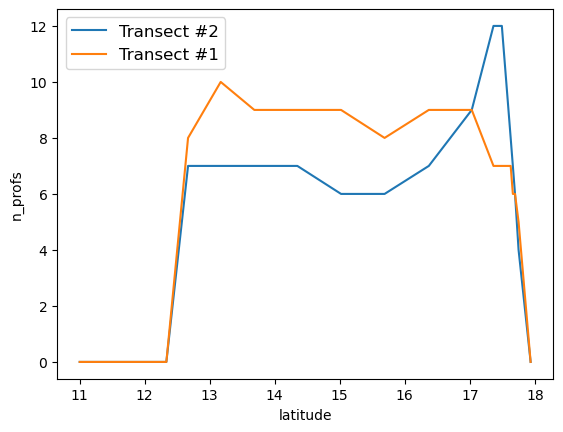

In [14]:
transect2_ds_interp.n_profs.plot(label='Transect #2')
transect1_ds_interp.n_profs.plot(label='Transect #1')
plt.legend(fontsize=fontsize)

Text(0.5, 1.0, 'Transect #1')

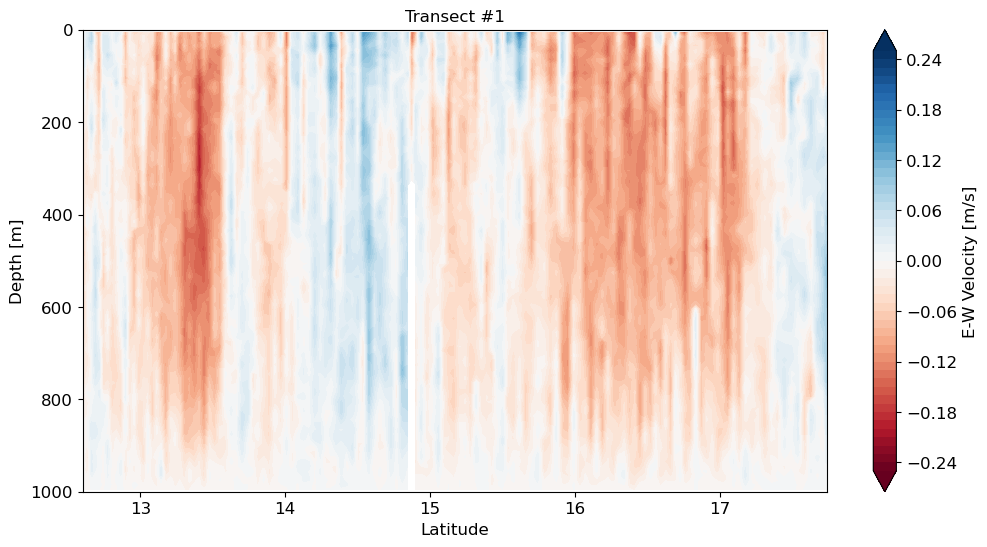

In [15]:
plt.figure(figsize=(12,6))
plt.contourf(transect1_ds.latitude,transect1_ds.depth,transect1_ds.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #1 (Interp)')

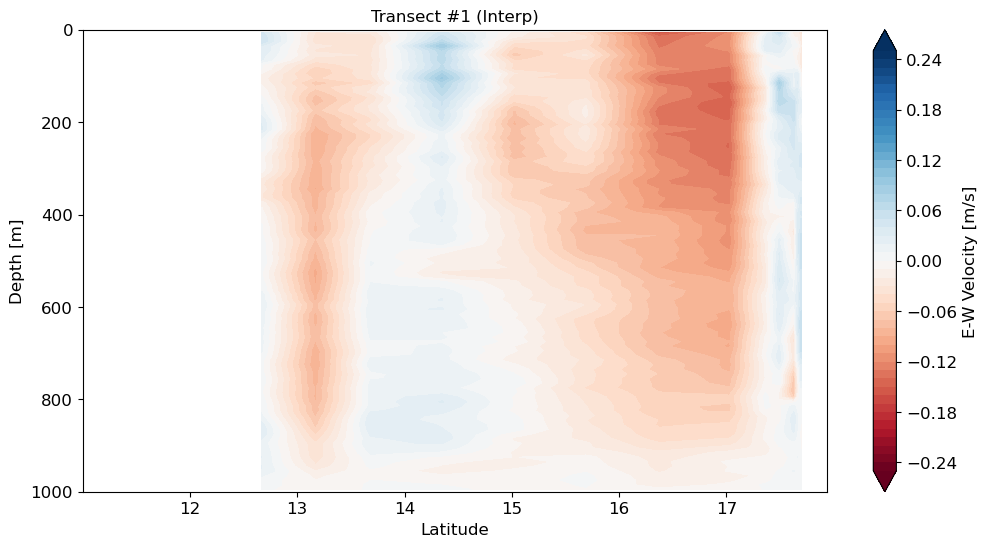

In [16]:
plt.figure(figsize=(12,6))
plt.contourf(transect1_ds_interp.latitude,transect1_ds_interp.depth,transect1_ds_interp.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1 (Interp)',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #1')

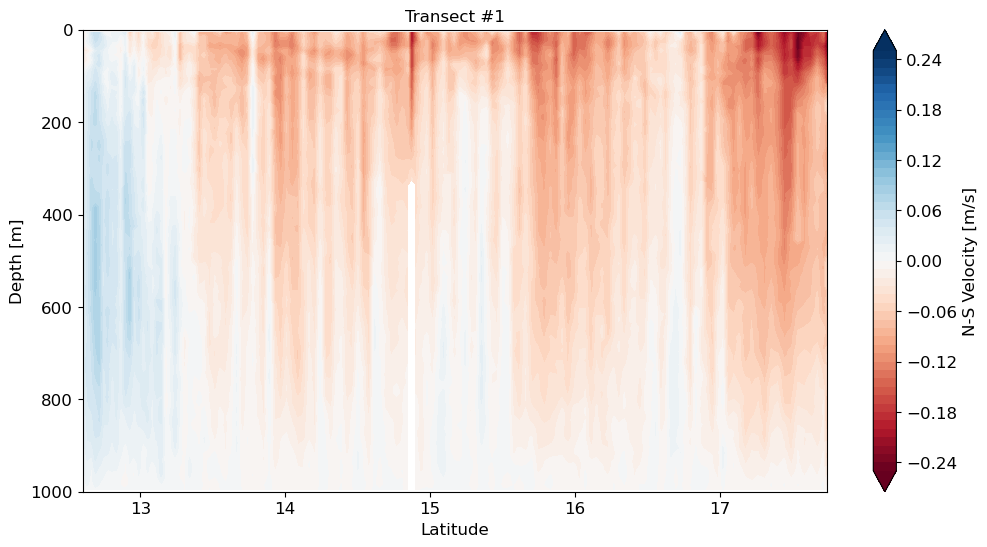

In [17]:
plt.figure(figsize=(12,6))
plt.contourf(transect1_ds.latitude,transect1_ds.depth,transect1_ds.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)


plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='N-S Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #1 (Interp)')

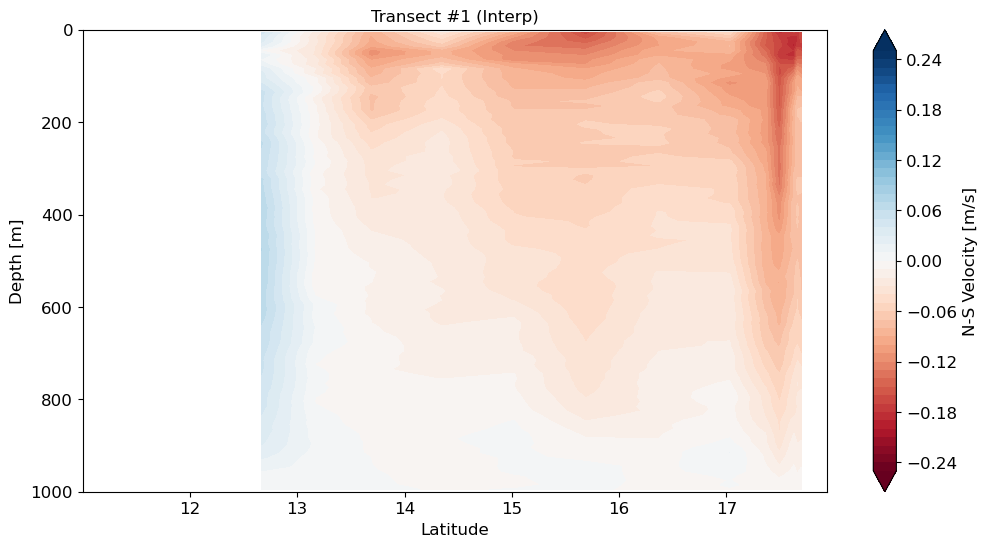

In [18]:
plt.figure(figsize=(12,6))
plt.contourf(transect1_ds_interp.latitude,transect1_ds_interp.depth,transect1_ds_interp.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)


plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='N-S Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #1 (Interp)',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #2')

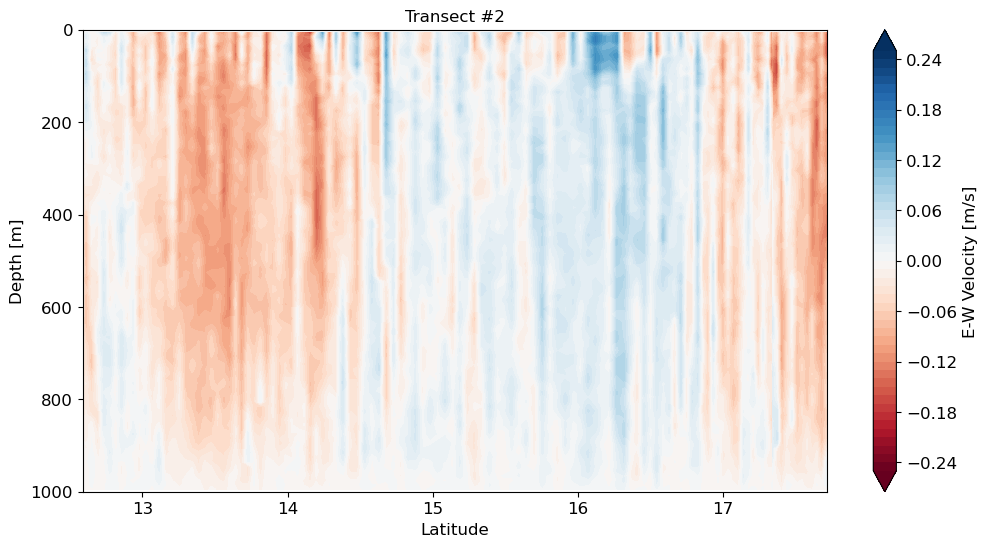

In [19]:
plt.figure(figsize=(12,6))
plt.contourf(transect2_ds.latitude,transect2_ds.depth,transect2_ds.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #2',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #2 (Interp)')

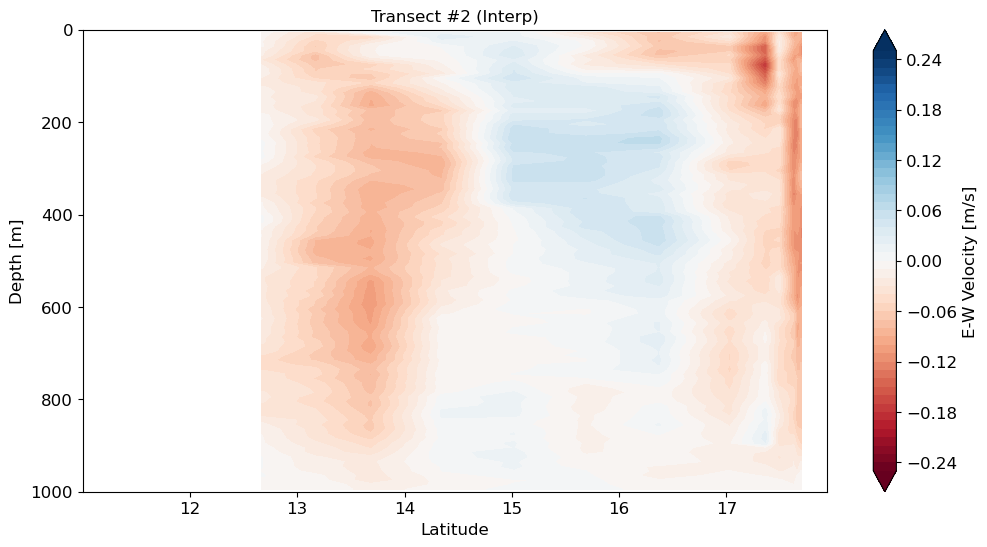

In [20]:
plt.figure(figsize=(12,6))
plt.contourf(transect2_ds_interp.latitude,transect2_ds_interp.depth,transect2_ds_interp.u_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='E-W Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #2 (Interp)',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #2')

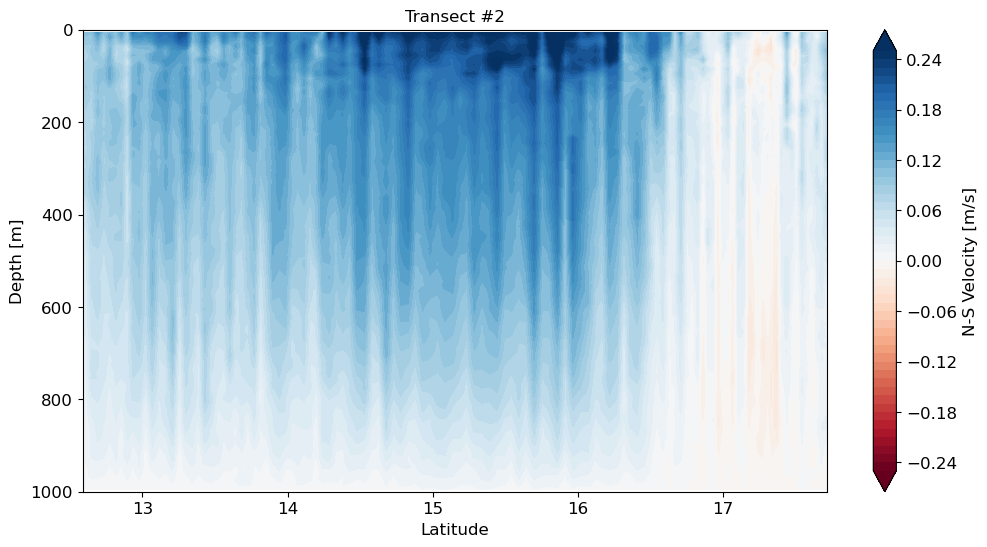

In [21]:
plt.figure(figsize=(12,6))
plt.contourf(transect2_ds.latitude,transect2_ds.depth,transect2_ds.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='N-S Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #2',fontsize=fontsize)



Text(0.5, 1.0, 'Transect #2 (Interp)')

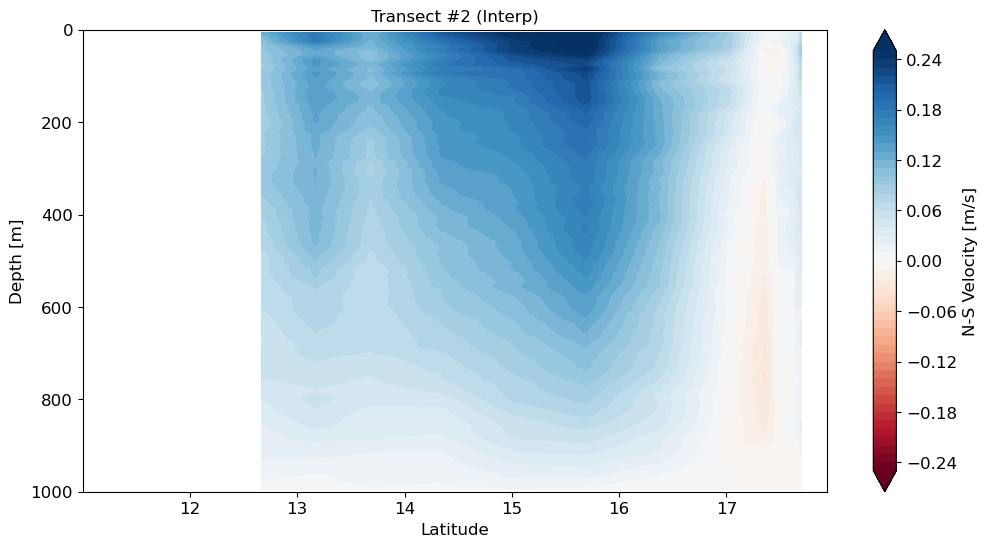

In [22]:
plt.figure(figsize=(12,6))
plt.contourf(transect2_ds_interp.latitude,transect2_ds_interp.depth,transect2_ds_interp.v_grid,levels=np.arange(-0.25,0.26,0.01),cmap='RdBu',extend='both')
plt.ylim(1000,0)

plt.ylabel('Depth [m]',fontsize=fontsize)
plt.xlabel('Latitude',fontsize=fontsize)
cb = plt.colorbar()
cb.set_label(label='N-S Velocity [m/s]',size=fontsize)
cb.ax.tick_params(labelsize=fontsize)
plt.gca().tick_params(axis='both', which='major', labelsize=fontsize)
plt.title('Transect #2 (Interp)',fontsize=fontsize)



## Calculate transport

In [23]:
transect1_ds = calc_segment_transport(transect1_ds)
transect2_ds = calc_segment_transport(transect2_ds)

transect1_ds_interp = calc_segment_transport_interp(transect1_ds_interp)
transect2_ds_interp = calc_segment_transport_interp(transect2_ds_interp)


In [24]:
print('Transect #1 Transport',np.nansum(transect1_ds.segment_transport)/(10**6),'Sv')
print('Transect #2 Transport',np.nansum(transect2_ds.segment_transport)/(10**6),'Sv')

print('Transect #1 Interp like WOCE Transport',np.nansum(transect1_ds_interp.segment_transport)/(10**6),'Sv')
print('Transect #2 Interp like WOCE Transport',np.nansum(transect2_ds_interp.segment_transport)/(10**6),'Sv')


Transect #1 Transport -17.458226787765238 Sv
Transect #2 Transport -9.44354299196649 Sv
Transect #1 Interp like WOCE Transport -9.071952058203314 Sv
Transect #2 Interp like WOCE Transport -17.55405207427675 Sv


Text(0, 0.5, 'Latitude')

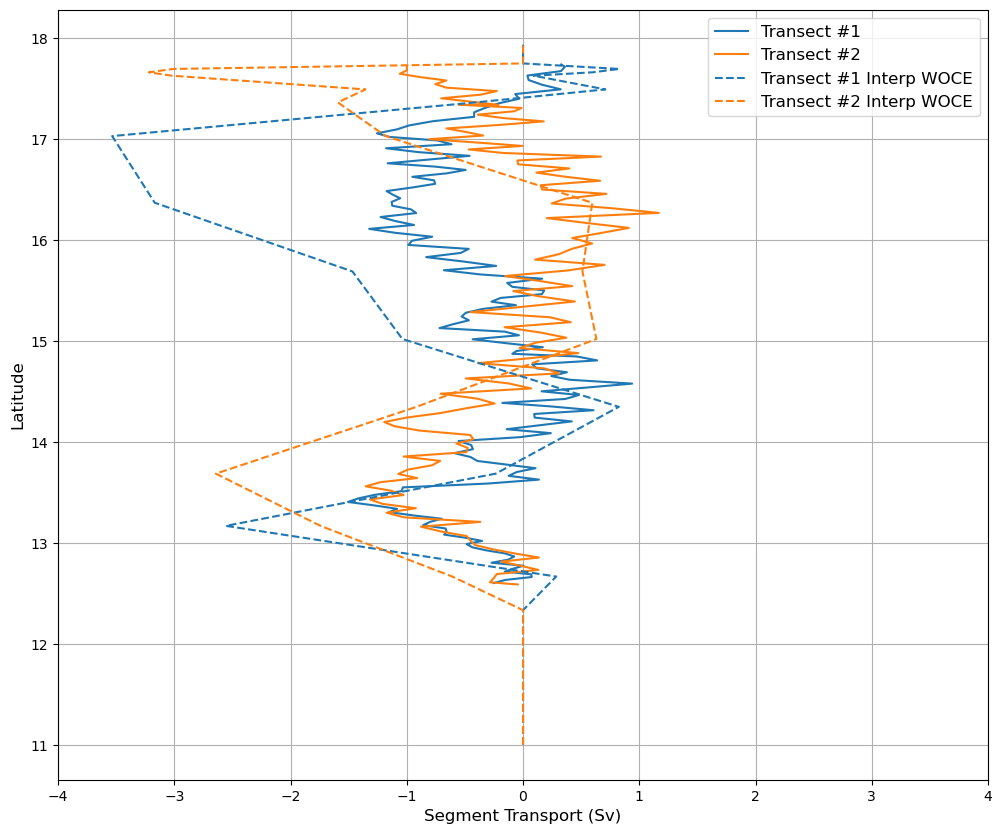

In [25]:
plt.figure(figsize=(12, 10))
plt.plot(transect1_ds.segment_transport/10**(5.5),transect1_ds.latitude,label='Transect #1',color='tab:blue')
plt.plot(transect2_ds.segment_transport/10**(5.5),transect2_ds.latitude,label='Transect #2',color='tab:orange')

plt.plot(transect1_ds_interp.segment_transport/1e6,transect1_ds_interp.latitude,'--',label='Transect #1 Interp WOCE',color='tab:blue')
plt.plot(transect2_ds_interp.segment_transport/1e6,transect2_ds_interp.latitude,'--',label='Transect #2 Interp WOCE',color='tab:orange')
plt.xlim(-4,4)
plt.grid()
plt.legend(fontsize=fontsize)
plt.xlabel('Segment Transport (Sv)',fontsize=fontsize)
plt.ylabel('Latitude',fontsize=fontsize)